## Compute cancer-type-specific differential expression scores for each gene

Compares tumor to normal tissue in the same patient.

In [1]:
import os

import pandas
import numpy
from scipy.stats import ttest_1samp

In [2]:
path = os.path.join('data', 'complete', 'expression-matrix.tsv.bz2')
expr_df = pandas.read_table(path, index_col=0)

In [3]:
path = os.path.join('data', 'complete', 'samples.tsv')
sample_df = (
    pandas.read_table(path)
    # Filter for samples with expression
    .query("sample_id in @expr_df.index")
)
patient_df = sample_df[['patient_id', 'acronym']].drop_duplicates()
sample_df.head(2)

,sample_id,patient_id,sample_type,disease,acronym,organ_of_origin,gender,age_diagnosed,dead,days_survived,recurred,days_recurrence_free
35,TCGA-02-0047-01,TCGA-02-0047,Primary Tumor,glioblastoma multiforme,GBM,Brain,Male,78.0,1.0,448.0,NaN,NaN
40,TCGA-02-0055-01,TCGA-02-0055,Primary Tumor,glioblastoma multiforme,GBM,Brain,Female,62.0,1.0,76.0,NaN,NaN


In [4]:
type_df = sample_df.pivot('patient_id', 'sample_type', values='sample_id')
type_df = type_df[['Primary Tumor', 'Solid Tissue Normal']]
# Filter for paired samples
type_df = type_df[type_df.isnull().sum(axis='columns') == 0]
type_df = type_df.reset_index().merge(patient_df)
type_df.head(2)

sample_type,patient_id,Primary Tumor,Solid Tissue Normal,acronym
0,TCGA-22-4593,TCGA-22-4593-01,TCGA-22-4593-11,LUSC
1,TCGA-22-4609,TCGA-22-4609-01,TCGA-22-4609-11,LUSC


In [5]:
def get_diffex(subtype_df, expr_df):
    """
    For each gene, compute differential expression between paired tumor and normal tissue.
    """
    tumor_df = expr_df.loc[list(subtype_df['Primary Tumor']), :]
    normal_df = expr_df.loc[list(subtype_df['Solid Tissue Normal']), :]
    for df in tumor_df, normal_df:
        df.index = subtype_df.index
    
    diffex_df = tumor_df - normal_df
    ttest = ttest_1samp(diffex_df, popmean=0, axis=0)

    df = pandas.DataFrame.from_items([
        ('entrez_gene_id', diffex_df.columns),
        ('patients', len(diffex_df)),
        ('tumor_mean', tumor_df.mean()),
        ('normal_mean', normal_df.mean()),
        ('mean_diff', diffex_df.mean()),
        ('t_stat', ttest.statistic),
        ('mlog10_p_value', -numpy.log10(ttest.pvalue)),
    ])
    return df

In [6]:
diffex_df = (type_df
    .groupby('acronym')
    .apply(get_diffex, expr_df=expr_df)
    .reset_index('acronym')
    .query("patients >= 5")
)

diffex_df.entrez_gene_id = diffex_df.entrez_gene_id.astype(int)

In [7]:
# Add gene symbols
path = os.path.join('data', 'expression-genes.tsv')
gene_df = pandas.read_table(path, low_memory=False)
gene_df = gene_df[['entrez_gene_id', 'symbol']]
len(gene_df)

20468

In [8]:
diffex_df = diffex_df.merge(gene_df, how='left')
diffex_df.tail()

,acronym,entrez_gene_id,patients,tumor_mean,normal_mean,mean_diff,t_stat,mlog10_p_value,symbol
347951,UCEC,100507436,7,8.141429,9.184286,-1.042857,-2.978566,1.607613,MICA
347952,UCEC,100652748,7,10.587143,9.198571,1.388571,4.362533,2.322631,TIMM23B
347953,UCEC,101060321,7,5.015714,1.569286,3.446429,2.192936,1.150042,TBC1D3G
347954,UCEC,102723547,7,0.840143,0.237143,0.603000,2.251617,1.185114,CSAG2
347955,UCEC,102724631,7,0.000000,0.000000,0.000000,NaN,NaN,POTEB3


In [9]:
path = os.path.join('data', 'complete', 'differential-expression.tsv.bz2')
diffex_df.to_csv(path, sep='\t', index=False, compression='bz2', float_format='%.4g')

In [10]:
# Patients with paired samples per disease
path = os.path.join('download', 'diseases.tsv')
acronym_df = pandas.read_table(path)

(type_df.acronym
    .value_counts().rename('patients')
    .reset_index().rename(columns={'index': 'acronym'})
    .merge(acronym_df)
    .sort_values('patients', ascending=False)
)

,acronym,patients,disease
0,BRCA,114,breast invasive carcinoma
1,KIRC,72,kidney clear cell carcinoma
2,THCA,59,thyroid carcinoma
3,LUAD,58,lung adenocarcinoma
4,PRAD,52,prostate adenocarcinoma
5,LUSC,51,lung squamous cell carcinoma
6,LIHC,50,liver hepatocellular carcinoma
7,HNSC,43,head & neck squamous cell carcinoma
8,KIRP,32,kidney papillary cell carcinoma
9,STAD,32,stomach adenocarcinoma


# Reduce expression dimensionality with NMF

In [11]:
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

In [12]:
nmf = NMF(n_components=100, random_state=0)
expr_nmf_df = nmf.fit_transform(expr_df)
expr_nmf_df = pandas.DataFrame(expr_nmf_df, index=expr_df.index)
expr_nmf_df.iloc[:5, :5]

,0,1,2,3,4
sample_id,,,,,
TCGA-02-0047-01,1.966827,0.977209,0.000000,0.000000,0.015947
TCGA-02-0055-01,1.990994,0.006328,0.018105,0.004237,0.019024
TCGA-02-2483-01,1.879199,1.546118,0.000000,0.000000,0.000000
TCGA-02-2485-01,1.985402,0.380807,0.000000,0.000000,0.000000
TCGA-02-2486-01,2.075301,0.000000,0.000000,0.018277,0.021438


In [13]:
diffex_nmf_df = (type_df
    .groupby('acronym')
    .apply(get_diffex, expr_df=expr_nmf_df)
    .reset_index('acronym')
    .rename(columns={'entrez_gene_id': 'component'})
    .query("patients >= 5")
)
diffex_nmf_df.head(2)

,acronym,component,patients,tumor_mean,normal_mean,mean_diff,t_stat,mlog10_p_value
0,BLCA,0,19,2.124774,2.163064,-0.038290,-2.087921,1.289979
1,BLCA,1,19,0.021220,0.004735,0.016485,0.813664,0.370111


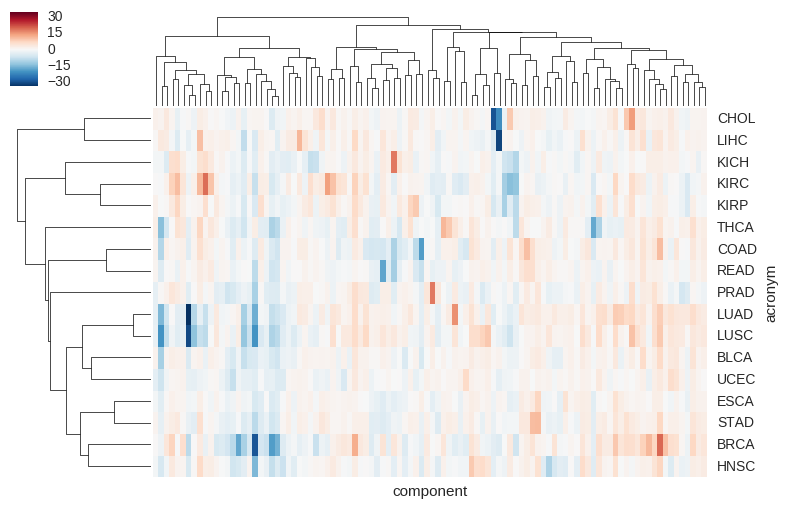

In [14]:
# Acronyms at https://github.com/cognoma/cancer-data/blob/master/download/diseases.tsv
plot_df = diffex_nmf_df.pivot(index='acronym', columns='component', values='t_stat').fillna(0)
grid = seaborn.clustermap(plot_df, metric='correlation', figsize=(9, 6))
grid.ax_heatmap.tick_params(labelbottom='off')
_ = plt.setp(grid.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)